# In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

## Instructions:

* **1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.**

>Done in the SQL file

* **2. Read the data into a Pandas dataframe.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import connect
from getpass import getpass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
db = connect(
        host= "localhost",
        user = "root",
        passwd = getpass("Enter password: "),
        database= "sakila"
   )

Enter password: ········


In [3]:
# Get the dataframe from SQL with useful information

query = "select title, i.inventory_id, rental_rate, length, rental_date, return_date from rental r join inventory i on r.inventory_id = i.inventory_id join film f on f.film_id = i.film_id order by rental_date" 

df = pd.read_sql_query(query,db)
df

,title,inventory_id,rental_rate,length,rental_date,return_date
0,BLANKET BEVERLY,367,2.99,148,2005-05-24 22:53:30,2005-05-26 22:04:30
1,FREAKY POCUS,1525,2.99,126,2005-05-24 22:54:33,2005-05-28 19:40:33
2,GRADUATE LORD,1711,2.99,156,2005-05-24 23:03:39,2005-06-01 22:12:39
3,LOVE SUICIDES,2452,0.99,181,2005-05-24 23:04:41,2005-06-03 01:43:41
4,IDOLS SNATCHERS,2079,2.99,84,2005-05-24 23:05:21,2005-06-02 04:33:21
...,...,...,...,...,...,...
16040,ENOUGH RAGING,1295,2.99,158,2006-02-14 15:16:03,NaT
16041,FALCON VOLUME,1358,4.99,102,2006-02-14 15:16:03,NaT
16042,FAMILY SWEET,1367,0.99,155,2006-02-14 15:16:03,NaT
16043,FAMILY SWEET,1369,0.99,155,2006-02-14 15:16:03,NaT


* **3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16045 entries, 0 to 16044
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         16045 non-null  object        
 1   inventory_id  16045 non-null  int64         
 2   rental_rate   16045 non-null  float64       
 3   length        16045 non-null  int64         
 4   rental_date   16045 non-null  datetime64[ns]
 5   return_date   15861 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 752.2+ KB


In [5]:
df.isna().sum()/len(df.return_date)

title           0.000000
inventory_id    0.000000
rental_rate     0.000000
length          0.000000
rental_date     0.000000
return_date     0.011468
dtype: float64

In [6]:
df.query('return_date != return_date') # These are all the films that we don't have any value for return_date

# We wanted to check this point to evaluate wich month consider as a "movie rented last month"

,title,inventory_id,rental_rate,length,rental_date,return_date
13987,ACADEMY DINOSAUR,6,0.99,86,2005-08-21 00:30:32,NaT
15862,FIGHT JAWBREAKER,1435,0.99,91,2006-02-14 15:16:03,NaT
15863,FLYING HOOK,1489,2.99,69,2006-02-14 15:16:03,NaT
15864,FORRESTER COMANCHEROS,1512,4.99,112,2006-02-14 15:16:03,NaT
15865,FRIDA SLIPPER,1540,2.99,73,2006-02-14 15:16:03,NaT
...,...,...,...,...,...,...
16040,ENOUGH RAGING,1295,2.99,158,2006-02-14 15:16:03,NaT
16041,FALCON VOLUME,1358,4.99,102,2006-02-14 15:16:03,NaT
16042,FAMILY SWEET,1367,0.99,155,2006-02-14 15:16:03,NaT
16043,FAMILY SWEET,1369,0.99,155,2006-02-14 15:16:03,NaT


### Conclusion: 
>After the above explorations we decided to to build our logistic regression model trying to predict film rentals for September 2005 based on data from May, June, July and August 2005. Any data from different dates (February 2006 and a singular data entry from August 2022) will not be included in our model.

In [7]:
# Changing the values of the column "rental_date" in order to have the month and the year and reducing as many options

df['rental_date'] = df['rental_date'].apply(lambda x: x.strftime('%B-%Y'))

In [8]:
df.rental_date.unique()

array(['May-2005', 'June-2005', 'July-2005', 'August-2005',
       'February-2006', 'August-2022'], dtype=object)

In [9]:
df

,title,inventory_id,rental_rate,length,rental_date,return_date
0,BLANKET BEVERLY,367,2.99,148,May-2005,2005-05-26 22:04:30
1,FREAKY POCUS,1525,2.99,126,May-2005,2005-05-28 19:40:33
2,GRADUATE LORD,1711,2.99,156,May-2005,2005-06-01 22:12:39
3,LOVE SUICIDES,2452,0.99,181,May-2005,2005-06-03 01:43:41
4,IDOLS SNATCHERS,2079,2.99,84,May-2005,2005-06-02 04:33:21
...,...,...,...,...,...,...
16040,ENOUGH RAGING,1295,2.99,158,February-2006,NaT
16041,FALCON VOLUME,1358,4.99,102,February-2006,NaT
16042,FAMILY SWEET,1367,0.99,155,February-2006,NaT
16043,FAMILY SWEET,1369,0.99,155,February-2006,NaT


In [10]:
# Getting only the rows we are interested in and renaming the dataframe

df1 = df[df["rental_date"].isin(['May-2005', 'June-2005', 'July-2005', 'August-2005'])]
df1

,title,inventory_id,rental_rate,length,rental_date,return_date
0,BLANKET BEVERLY,367,2.99,148,May-2005,2005-05-26 22:04:30
1,FREAKY POCUS,1525,2.99,126,May-2005,2005-05-28 19:40:33
2,GRADUATE LORD,1711,2.99,156,May-2005,2005-06-01 22:12:39
3,LOVE SUICIDES,2452,0.99,181,May-2005,2005-06-03 01:43:41
4,IDOLS SNATCHERS,2079,2.99,84,May-2005,2005-06-02 04:33:21
...,...,...,...,...,...,...
15857,COMANCHEROS ENEMY,772,0.99,67,August-2005,2005-08-25 23:54:26
15858,VOYAGE LEGALLY,4364,0.99,78,August-2005,2005-08-27 18:02:47
15859,ILLUSION AMELIE,2088,0.99,122,August-2005,2005-08-25 02:48:48
15860,HUNCHBACK IMPOSSIBLE,2019,4.99,151,August-2005,2005-08-31 21:33:07


In [11]:
# Sanity check

df1.rental_date.unique()

array(['May-2005', 'June-2005', 'July-2005', 'August-2005'], dtype=object)

In [12]:
# Dropping the column return_date due to useless by now

df1.drop(["return_date"], axis=1, inplace = True)
df1.head()

,title,inventory_id,rental_rate,length,rental_date
0,BLANKET BEVERLY,367,2.99,148,May-2005
1,FREAKY POCUS,1525,2.99,126,May-2005
2,GRADUATE LORD,1711,2.99,156,May-2005
3,LOVE SUICIDES,2452,0.99,181,May-2005
4,IDOLS SNATCHERS,2079,2.99,84,May-2005



* **4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.**


In [13]:
# Creating a new column to show if the movie was rented the previous month or not

def rental_last_mont(x):  
    if x['rental_date'] == 'August-2005':
        return 1
    else:
        return 0
    
df1['rented_last_mont'] = df1.apply(lambda x: rental_last_mont(x), axis=1)
df1

,title,inventory_id,rental_rate,length,rental_date,rented_last_mont
0,BLANKET BEVERLY,367,2.99,148,May-2005,0
1,FREAKY POCUS,1525,2.99,126,May-2005,0
2,GRADUATE LORD,1711,2.99,156,May-2005,0
3,LOVE SUICIDES,2452,0.99,181,May-2005,0
4,IDOLS SNATCHERS,2079,2.99,84,May-2005,0
...,...,...,...,...,...,...
15857,COMANCHEROS ENEMY,772,0.99,67,August-2005,1
15858,VOYAGE LEGALLY,4364,0.99,78,August-2005,1
15859,ILLUSION AMELIE,2088,0.99,122,August-2005,1
15860,HUNCHBACK IMPOSSIBLE,2019,4.99,151,August-2005,1


In [14]:
# Checking the distribution of the target variable

df1.rented_last_mont.value_counts(normalize=True)

0    0.641533
1    0.358467
Name: rented_last_mont, dtype: float64

In [15]:
# Checking the Dtype of the features

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15862 entries, 0 to 15861
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             15862 non-null  object 
 1   inventory_id      15862 non-null  int64  
 2   rental_rate       15862 non-null  float64
 3   length            15862 non-null  int64  
 4   rental_date       15862 non-null  object 
 5   rented_last_mont  15862 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 867.5+ KB


In [16]:
# Converting the object ones to strings

df1.title = df1.title.astype("string")
df1.rental_date = df1.rental_date.astype("string")

In [17]:
# Sanity check

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15862 entries, 0 to 15861
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             15862 non-null  string 
 1   inventory_id      15862 non-null  int64  
 2   rental_rate       15862 non-null  float64
 3   length            15862 non-null  int64  
 4   rental_date       15862 non-null  string 
 5   rented_last_mont  15862 non-null  int64  
dtypes: float64(1), int64(3), string(2)
memory usage: 867.5 KB


* **5. Create a logistic regression model to predict this variable from the cleaned data.**

In [18]:
# Transforming categorical features into numerical

le = LabelEncoder()
df1.title = le.fit_transform(df1.title)
df1.rental_date = le.fit_transform(df1.rental_date)

In [19]:
# Splitting into explanative and target variable

X = df1.iloc[:, :-1]
y = df1.rented_last_mont

In [20]:
# Division of the dataset into trains and a test set

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state=0)

In [21]:
# Checking if every done value matches

print("Number of rows of X_train = {}".format(len(X_train)))
print("Number of rows of X_test = {}".format(len(X_test)))
print("Number of rows of y_train= {}".format(len(y_train)))
print("Number of rows of y_test = {}".format(len(y_test)))
print("Percentage of train values = {}".format(round(len(X_train)/len(X), 4) * 100),"%")

Number of rows of X_train = 11896
Number of rows of X_test = 3966
Number of rows of y_train= 11896
Number of rows of y_test = 3966
Percentage of train values = 75.0 %


In [22]:
# Preprocessing X_train and X_test

scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Train the model

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [24]:
# Create predictions for the X_train

pred_train = classifier.predict(X_train)
pred_train

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [25]:
# Checking the probability of the predictions for the X_train

prob_train = classifier.predict_proba(X_train)
prob_train

array([[2.35399238e-03, 9.97646008e-01],
       [9.98038326e-01, 1.96167385e-03],
       [9.98022011e-01, 1.97798884e-03],
       ...,
       [9.98025681e-01, 1.97431917e-03],
       [2.29238042e-03, 9.97707620e-01],
       [9.99999991e-01, 8.53959909e-09]])

In [26]:
# Create predictions for the X_train

pred_test = classifier.predict(X_test)
pred_test

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [27]:
# Checking the probability of the predictions for the X_train

prob_test = classifier.predict_proba(X_test)
prob_test

array([[9.98111184e-01, 1.88881565e-03],
       [9.99999991e-01, 8.81633439e-09],
       [2.24488469e-03, 9.97755115e-01],
       ...,
       [2.27789227e-03, 9.97722108e-01],
       [9.98008372e-01, 1.99162802e-03],
       [9.98033774e-01, 1.96622630e-03]])

* **6. Evaluate the results.**

In [28]:
# The results of the probability are weird, we have to analize them further

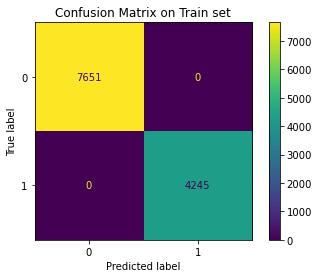

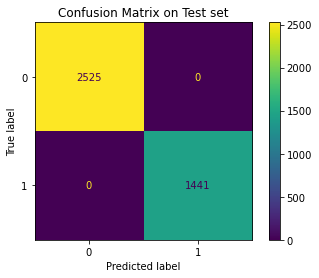

In [29]:
# Plotting Confusion Matrix for Train and Test set

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, ax=ax)
plt.show()

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax)
plt.show()

In [30]:
# It's amazing that our model didn't learn any false positive or false negative

In [31]:
# Printing the classification report to see the results more detailed

print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7651
           1       1.00      1.00      1.00      4245

    accuracy                           1.00     11896
   macro avg       1.00      1.00      1.00     11896
weighted avg       1.00      1.00      1.00     11896

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2525
           1       1.00      1.00      1.00      1441

    accuracy                           1.00      3966
   macro avg       1.00      1.00      1.00      3966
weighted avg       1.00      1.00      1.00      3966



### CONCLUSION:
>The results are too good to being considered correctly. There is probably a collinearity between some of the features or the fact that we have only one month to consider if a movie was rented or not, does that our model doesn't learn anything.